In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate
from scipy.optimize import curve_fit
from replay_condition import *

In [2]:
#test if it works with one participant and one image
# list of column names which needs to be string
lst_str_cols = ['identifier']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
# use dict on dtypes
df = pd.read_csv("../separate_participant_data/Raw_Data/raw_subj_1.dat", sep = ",", dtype=dict_dtypes)
df_im = df[df.imageno==50]

In [3]:
kwargs = {"window_length":13,"polyorder":2,"mode":"nearest"}
df_filtered = sav_gol(df_im, **kwargs)

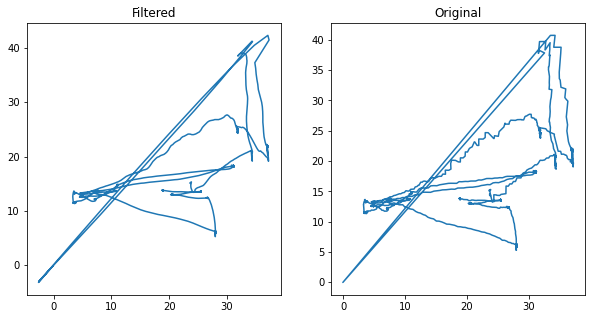

In [4]:
#Comparison between filtered and non-filtered:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.plot(df_filtered.x, df_filtered.y)
ax0.set_title("Filtered")
ax1.plot(df_im.x, df_im.y)
ax1.set_title("Original")
plt.show()

In [5]:
df_upsampled = upsampling(df_filtered)

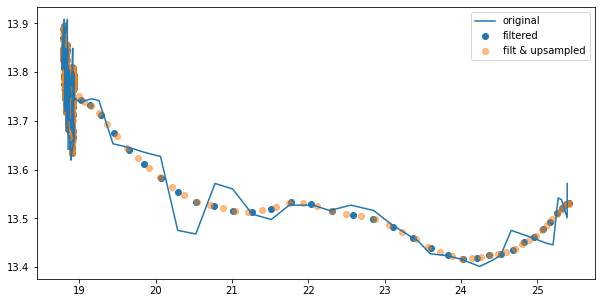

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(df_filtered[(df_filtered.identifier=="00100101")].x,
         df_filtered[(df_filtered.identifier=="00100101")].y, label = "filtered")
plt.scatter(df_upsampled[(df_upsampled.identifier=="00100101")].x,
         df_upsampled[(df_upsampled.identifier=="00100101")].y, 
            label="filt & upsampled", alpha=0.5)
plt.plot(df_im[(df_im.identifier=="00100101")].x,
         df_im[(df_im.identifier=="00100101")].y, label = "original")
plt.legend()

In [7]:
df_contrast = add_contrast(df_upsampled)

00100101
in


# For invalid saccades:
__If we have an invalid sequence, only ramp up in the last invalid event.__

# contrast needs to be handled in two steps: First insert the contrast for the invalid saccades and
# fixations, then insert the contrast for the remaining saccades.

contrast = np.ones(len(df_upsampled))
df_upsampled.insert(7, "contrast", contrast)

ident = np.unique(np.asarray(df_upsampled.identifier))

# In order to fit the Gaussian to the invalid sections we need:
mean = 100
std = 35
# get the number of time steps that correspond to 100ms
n_t_steps = int(mean / dt)

for ids in ident:
    df_temp = df_upsampled[(df_upsampled.identifier == ids) & (df_upsampled.invalid == 1)]
    if len(df_temp) > 0:
        start = df_temp.index[0]
        end = df_temp.index[-1]
        dur_invalid = (end - start).total_seconds() * 1e3  # duration of invalid interval in ms
        # we need to check if this is bigger than 200ms
        tot_t_steps = len(df_temp)  # get the total number of invalid time steps

        if dur_invalid / 2 > mean:
            x_gauss_down = np.linspace(0, mean, n_t_steps)
            contrast_gauss = norm_inverse_gauss(x_gauss_down, mean, std)
            plateau = np.zeros(tot_t_steps - 2 * n_t_steps)
            x_gauss_up = np.linspace(mean, 2 * mean, n_t_steps)
            contrast_gauss_up = norm_inverse_gauss(x_gauss_up, mean, std)
            contrast_temp = np.append(contrast_gauss, plateau)
            contrast_invalid = np.append(contrast_temp, contrast_gauss_up)
            assert (len(contrast_invalid) == tot_t_steps)
        else:
            x_gauss = np.linspace(0, 200, tot_t_steps)
            contrast_invalid = norm_inverse_gauss(x_gauss, mean, std)

        df_upsampled.loc[(df_upsampled.identifier == ids) & (df_upsampled.invalid == 1),
                         "contrast"] = contrast_invalid



In [34]:
df_upsampled[ (df_upsampled.invalid == 1)]

,identifier,time,x,y,pupil,imageno,invalid,contrast,filtertype,is_saccade,filterregion,targetpresent,expectedlocation
00:00:05.155552,00100117,4244380,37.112185,19.988135,10597.0,50,1,1.000000,1,0,2,0,0
00:00:05.156246,00100117,4244381,37.080178,20.290997,10597.0,50,1,0.998995,1,0,2,0,0
00:00:05.156941,00100117,4244381,37.041995,20.629355,10597.0,50,1,0.997939,1,0,2,0,0
00:00:05.157635,00100117,4244382,37.013319,20.991394,9914.0,50,1,0.996829,1,0,2,0,0
00:00:05.158330,00100117,4244383,36.984190,21.328582,9914.0,50,1,0.995664,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:05.823607,00100121,4245048,23.650521,15.210070,10293.0,50,1,0.688713,1,0,2,0,0
00:00:05.824301,00100121,4245049,23.627029,15.191946,10268.0,50,1,0.830583,1,0,2,0,0
00:00:05.824996,00100121,4245049,23.605701,15.174158,10268.0,50,1,0.922567,1,0,2,0,0
00:00:05.825690,00100121,4245050,23.590145,15.158550,10268.0,50,1,0.974409,1,0,2,0,0


# Add contrast function - loop not working!

In [8]:
ident = np.unique(np.asarray(df_contrast.identifier))

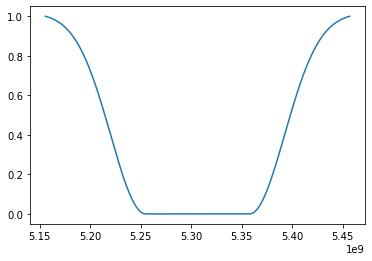

In [9]:
plt.plot(df_upsampled[(df_upsampled.identifier=="00100117") & (df_upsampled.invalid==1)].contrast)

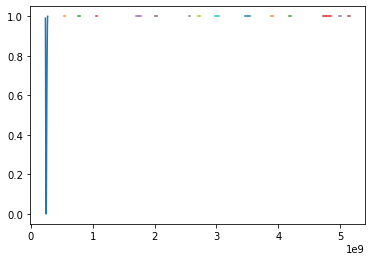

In [10]:
for ids in ident:
    df_valid = df_upsampled[(df_upsampled.identifier == ids) &
                            (df_upsampled.is_saccade == 1) & (df_upsampled.invalid == 0)]
    if len(df_valid)>0:
        plt.plot(df_valid.contrast)

In [11]:
%%time

import warnings

warnings.filterwarnings('ignore')

params = []
sacc_durations = []
for ids in ident:
    df_valid = df_upsampled[(df_upsampled.identifier == ids) &
                            (df_upsampled.is_saccade == 1) & (df_upsampled.invalid == 0)]
    if len(df_valid) > 0:
        tot_val_steps = len(df_valid)
        delta_df = delta_position(df_valid)
        delta_df = delta_df/ np.max(delta_df)
        t_delta = np.asarray(delta_df.index.total_seconds()) * 1e3  # time in ms
        t_delta = t_delta - t_delta[0]
        sacc_durations.append(t_delta[-1])
        
        # we need to chose initial guesses for our t0 and b
        # for that we do a gridsearch, getting the Gumbel to every possible combination
        # and then doing the residuals squared sum
        # Empirically it looked ok to:
        # 1. Vary t0 initial value from 1/4 to 3/4 of the saccade duration. 
        # 2. Vary b from 1/saccade_duration to saccade_duration/2
        t0_range = np.linspace(t_delta[-1]/4,3*t_delta[-1]/4)
        b_range = np.linspace(1/t_delta[-1],t_delta[-1]/2)
        tt,bb = np.meshgrid(t0_range,b_range, sparse=True)
        
        gumbel_meshed = []
        for t in t_delta:
            zz = func_Gumbel(t,tt,bb)
            gumbel_meshed.append(zz)
        
        gumbel_meshed = np.asarray(gumbel_meshed)     
        residuals = np.sum((gumbel_meshed-delta_df[:, np.newaxis,np.newaxis])**2,axis=0)
        
        # we take as initial conditions the combination that has minimum residual 
        idx_min = np.unravel_index(np.argmin(residuals, axis=None), residuals.shape)
        t0_initial = tt[0,idx_min[0]]
        b_initial = bb[idx_min[1],0]
        
               
        
        # fit Gumbel CDF
        popt_Gumbel, _ = curve_fit(func_Gumbel, t_delta, delta_df, p0=[t0_initial,b_initial])
        params.append(popt_Gumbel)
        # Normalize the derivative after inverting
        contrast_valid = NormalizeData(-np.diff(func_Gumbel(t_delta, *popt_Gumbel)))
        contrast_valid = np.concatenate((contrast_valid, [1]))

        assert (len(contrast_valid) == tot_val_steps)

        df_upsampled.loc[(df_upsampled.identifier == ids) &
                         (df_upsampled.is_saccade == 1) & (df_upsampled.invalid == 0),
                         "contrast"] = contrast_valid
        
        
        

   

CPU times: user 199 ms, sys: 7.87 ms, total: 207 ms
Wall time: 205 ms


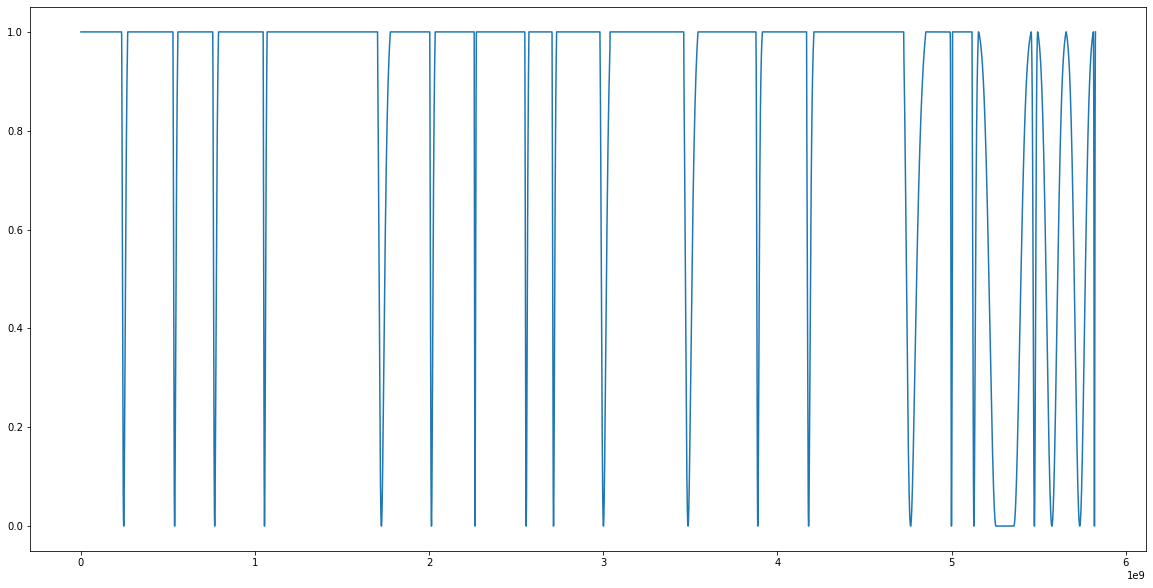

In [14]:
plt.figure(figsize=(20,10))
plt.plot(df_upsampled.contrast)

# Vary t0 initial value from 1/4 to 3/4 of the saccade duration. 
# Vary b from 1/sacc_duration to sacc_duration/2

# Save t0 and b temporarily for every participant and every trial and if I cant find a fit, then I take a t0 that depends on the saccade duration and a random b. 